In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import re

c:\Users\edgar\anaconda3\envs\bert_pln_olist\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Carregar os dados
data = pd.read_csv("https://raw.githubusercontent.com/GabrielVCoutinho/Machine_Learning/main/olist_order_reviews_dataset.csv")
data_clean = data[['review_comment_message', 'review_score']].dropna(subset=['review_comment_message'])
data_clean = data_clean.rename(columns={'review_comment_message': 'texto'})
data_clean = data_clean[['texto', 'review_score']]

# Filtrar e mapear os rótulos
binary_data = data_clean[data_clean['review_score'].isin([1, 2, 4, 5])]
score_map = {1: 0, 2: 0, 4: 1, 5: 1}
binary_data['binary_label'] = binary_data['review_score'].map(score_map)
binary_data = binary_data[['texto', 'binary_label']]

# Função de limpeza de texto (opcional)
def clean_review_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'R\$', 'dinheiro', text, flags=re.IGNORECASE)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = text.lower()
    return text

# Aplicar a função de limpeza (opcional)
binary_data["texto"] = binary_data["texto"].apply(clean_review_text)

# Preparar os dados
texts = binary_data['texto'].tolist()
labels = binary_data['binary_label'].tolist()

# Dividir em treino e teste
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Carregar o tokenizador e o modelo
model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenizar os textos
max_length = 128

train_encodings = tokenizer(
    train_texts, truncation=True, padding=True, max_length=max_length
)
test_encodings = tokenizer(
    test_texts, truncation=True, padding=True, max_length=max_length
)

# Converter para Datasets do TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

batch_size = 16
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Compilar o modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Treinar o modelo
epochs = 3
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs
)

# Avaliar o modelo
loss, accuracy = model.evaluate(test_dataset)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Fazer previsões
y_pred = []
y_true = []

for batch in test_dataset:
    inputs, labels = batch
    logits = model(inputs, training=False).logits
    predictions = tf.argmax(logits, axis=-1)
    y_pred.extend(predictions.numpy())
    y_true.extend(labels)

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=['Review Negativa', 'Review Positiva']))


C:\Users\edgar\AppData\Local\Temp\ipykernel_3276\1955594615.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['binary_label'] = binary_data['review_score'].map(score_map)
c:\Users\edgar\anaconda3\envs\bert_pln_olist\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifie

Epoch 1/3
1871/1871 [==============================] - 663s 347ms/step - loss: 0.1798 - accuracy: 0.9347 - val_loss: 0.1441 - val_accuracy: 0.9482
Epoch 2/3
1871/1871 [==============================] - 653s 349ms/step - loss: 0.1353 - accuracy: 0.9528 - val_loss: 0.1449 - val_accuracy: 0.9472
Epoch 3/3
468/468 [==============================] - 56s 119ms/step - loss: 0.1665 - accuracy: 0.9468
Loss: 0.16652534902095795
Accuracy: 0.9468199014663696
                 precision    recall  f1-score   support

Review Negativa       0.88      0.95      0.91      2191
Review Positiva       0.98      0.95      0.96      5293

       accuracy                           0.95      7484
      macro avg       0.93      0.95      0.94      7484
   weighted avg       0.95      0.95      0.95      7484



                 precision    recall  f1-score   support

Review Negativa       0.88      0.95      0.91      2191
Review Positiva       0.98      0.95      0.96      5293

       accuracy                           0.95      7484
      macro avg       0.93      0.95      0.94      7484
   weighted avg       0.95      0.95      0.95      7484



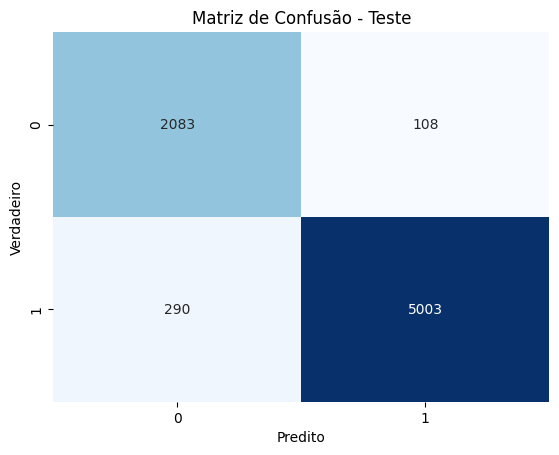

In [4]:
# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=['Review Negativa', 'Review Positiva']))

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

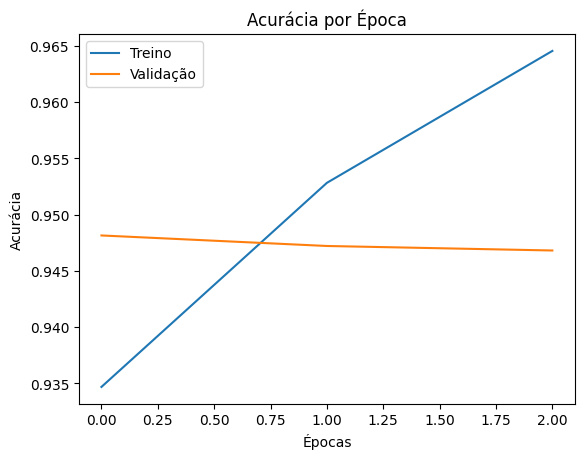

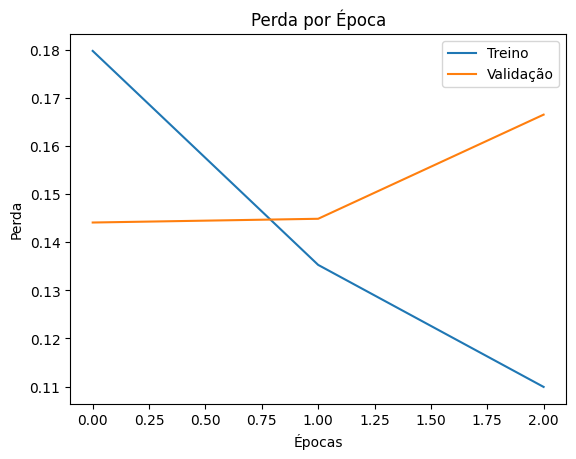

In [5]:
# Plotar o histórico de treinamento
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()